In [1]:
#18/05/21: stripped down version of IBM code for running locally on IBM Qsystem 1
import math
import certifi
# Importing standard Qiskit libraries and configuring account
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from scipy import stats

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer,BasicAer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools.visualization import circuit_drawer


MSE= 0.06203234672546386
mitigated MSE= nan
alt mitigated MSE= 0.03981675095753763
SQL= 0.001953125
quant adv= 0.0015869140625

SQL= 0.015625
quant adv= 0.0126953125
mse =  0.05014644219594095
mse og =  0.07236203796386718


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


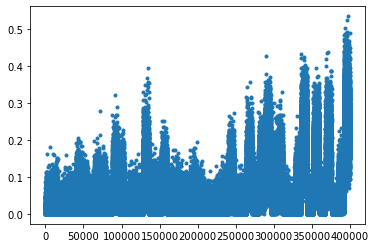

In [2]:
from scipy import stats
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
ii=complex(0,1)
#number of total repitions
nrep=50
#number of repitions for the training 
nrand=30
#number of times we make a measurement before recalibrating
nper=5
nrepT=round(nrep/nper)
#rotation angle
th=0
#decoherence
p=0.5
#no of shots 
shots=8192
shotseff=shots/2
grouping=8
shotseff2=shotseff/grouping
#results
mse2q1=[]
mse2qMIT1=[]
mse2qMIT_alt1=[]
alt_mse2qMIT1=[]
alt_mse2qMIT_alt1=[]

n00T=[]
n01T=[]
n10T=[]
n11T=[]


#estimator coefficients
chiX1 = 1/(1-p);
chiX2 = (3**(0.5)-1)/(2*(1-p));
chiX3 = -(3**(0.5)+1)/(2*(1-p));
chiX4 = 0;
chiY1 = -1/(1-p);
chiY2 = (3**(0.5)+1)/(2*(1-p));
chiY3 = (1-3**(0.5))/(2*(1-p));
chiY4 = 0;
    
predx=[]
predy=[]
predxMIT=[]
predyMIT=[]
cnameA='rigetti'
cname=cnameA

gradXA=[]
gradYA=[]
intXA=[]
intYA=[]

msealt=[]
msealt2=[]
for totcount in range(nrepT):
    thvec=np.linspace(-0.2,0.2,nrand)
    
    #loading real counts
    F = np.load(str(cname+str("_LR")+str("/")+str('run')+str(totcount)+str("_2Q_est")+str('th=')+str(th)+str('p=')+str(p)+str("/")+str("training_data")+str(".npz")))
    a=F['arr_0']
    n1=np.transpose(a)[0]
    n2=np.transpose(a)[1]
    n3=np.transpose(a)[2]
    n4=np.transpose(a)[3]
    noisy2QX=(chiX1*n1+chiX2*n2+chiX3*n3+chiX4*n4)*(1/4096)
    noisy2QY=(chiY1*n1+chiY2*n2+chiY3*n3+chiY4*n4)*(1/4096)
    
    #generating data to fit to
    clean2QX=[]
    True2QX=[]
    clean2QY=[]
    True2QY=[]
    thvec=np.linspace(-0.2,0.2,nrand)
    for jj in range(nrand):
        thint=thvec[jj]
        
        True2QX.append(thint)
        True2QY.append(thint)
    
    #regression
    res2QX_alt = stats.linregress(np.array(noisy2QX),np.array(True2QX))
    
    res2QY_alt = stats.linregress(np.array(noisy2QY),np.array(True2QX))
    

    gradXA.append(res2QX_alt.slope)
    gradYA.append(res2QY_alt.slope)
    
    intXA.append(res2QX_alt.intercept)
    intYA.append(res2QY_alt.intercept)
        
    #measurement results
    F00res = np.load(str(cname+str("_LR")+str("/")+str('run')+str(totcount)+str("_2Q_est")+str('th=')+str(th)+str('p=')+str(p)+str("/")+str("n00vec")+str(".npz")))
    a00res=F00res['arr_0']
    F01res = np.load(str(cname+str("_LR")+str("/")+str('run')+str(totcount)+str("_2Q_est")+str('th=')+str(th)+str('p=')+str(p)+str("/")+str("n01vec")+str(".npz")))
    a01res=F01res['arr_0']
    F10res = np.load(str(cname+str("_LR")+str("/")+str('run')+str(totcount)+str("_2Q_est")+str('th=')+str(th)+str('p=')+str(p)+str("/")+str("n10vec")+str(".npz")))
    a10res=F10res['arr_0']
    F11res = np.load(str(cname+str("_LR")+str("/")+str('run')+str(totcount)+str("_2Q_est")+str('th=')+str(th)+str('p=')+str(p)+str("/")+str("n11vec")+str(".npz")))
    a11res=F11res['arr_0']
    
    n1=np.transpose(a00res)
    n2=np.transpose(a01res)
    n3=np.transpose(a10res)
    n4=np.transpose(a11res)
    

    for new_count in range(nper):
        n00T.append(n1[new_count])
        n01T.append(n2[new_count])
        n10T.append(n3[new_count])
        n11T.append(n4[new_count])
    
    estX=(chiX1*n1+chiX2*n2+chiX3*n3+chiX4*n4)*(1/4096)
    estY=(chiY1*n1+chiY2*n2+chiY3*n3+chiY4*n4)*(1/4096)
    
    #mitigated results X
    estxMIT_Aalt=res2QX_alt.intercept + estX
    
    #mitigated results Y
    estyMIT_Aalt=res2QY_alt.intercept + estY

    mse2q1.append((estX-th)**2+(estY-th)**2)
    alt_mse2qMIT_alt1.append((estxMIT_Aalt-th)**2+(estyMIT_Aalt-th)**2)
    
    predx.append(estX)
    predy.append(estY)
    predxMIT.append(estxMIT_Aalt)
    predyMIT.append(estyMIT_Aalt)
    
    for jjj in range(nper):
        for outside in range(1000):

            data1=np.ones(int(shotseff))
            data1[:int(n1[jjj])] = 0
            data1[int(n1[jjj]):int(n1[jjj])+int(n2[jjj])] = 2
            data1[int(n2[jjj])+int(n1[jjj]):int(n3[jjj])+int(n2[jjj])+int(n1[jjj])] = 3
            np.random.shuffle(data1)


            for groupcount in range(grouping):
                dataint=data1[int(groupcount*shotseff2):int((groupcount+1)*shotseff2)]

                n1t=np.count_nonzero(dataint==0)
                n2t=np.count_nonzero(dataint==2)
                n3t=np.count_nonzero(dataint==3)
                n4t=np.count_nonzero(dataint==1)

                thx=(chiX1*n1t+chiX2*n2t+chiX3*n3t+chiX4*n4t)*(1/shotseff2)
                thy=(chiY1*n1t+chiY2*n2t+chiY3*n3t+chiY4*n4t)*(1/shotseff2)

                thx2=res2QX_alt.intercept+thx
                thy2=res2QY_alt.intercept+thy

                
                
                msealt.append((thx2-th)**2+(thy2-th)**2)
                msealt2.append((thx-th)**2+(thy-th)**2)

#                 msealtX.append((thx2-th)**2)
#                 msealtY.append((thy2-th)**2)
#                 estXaltMIT.append(thx2)
#                 estYaltMIT.append(thy2)

#                 estXalt.append(thx)
#                 estYalt.append(thy)

expvar=2/(((1-p)**2)*shotseff);
expvar2Q=2*(2-p+0.5*p**2)/(((1-p)**2)*shotseff*2);
expvar2=2/(((1-p)**2)*shotseff2);
expvar2Q2=2*(2-p+0.5*p**2)/(((1-p)**2)*shotseff2*2);

print("MSE=",np.mean(mse2q1))
print("mitigated MSE=",np.mean(alt_mse2qMIT1))
print("alt mitigated MSE=",np.mean(alt_mse2qMIT_alt1))
print("SQL=",expvar)
print("quant adv=",expvar2Q)

print()
print("SQL=",expvar2)
print("quant adv=",expvar2Q2)
print('mse = ',np.mean(msealt))
print('mse og = ',np.mean(msealt2))

plt.plot(msealt,'.')


8.085185040963898
0.04477270412717147
390765 400000


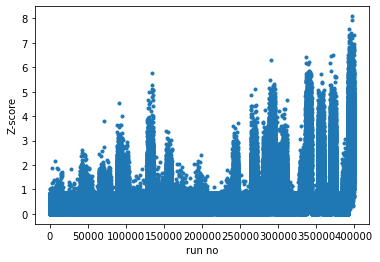

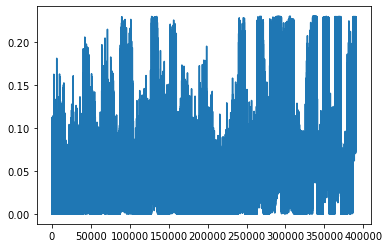

In [3]:
#removing outliers
from scipy import stats
import numpy as np

z = np.abs(stats.zscore(msealt))
print(np.max(z))

plt.plot(z,'.')
plt.ylabel('Z-score')
plt.xlabel('run no')
outlier=np.where(z>3)

mse_upd = np.array(msealt)[(z < 3)]
print(np.mean(mse_upd))

plt.figure(2)
plt.plot(mse_upd)

print(len(mse_upd),len(msealt))

In [4]:
#what fraction of the data is thrown away? :  need this for error bars
frac=len(mse_upd)/len(msealt)
print(frac)

0.9769125


In [5]:
print('2Q MSE final = ',np.mean(mse_upd))

2Q MSE final =  0.04477270412717147


In [6]:

print("Bootstrapping")
n1=sum(n00T)
n2=sum(n01T)
n3=sum(n10T)
n4=sum(n11T)

print(n1+n2+n3+n4)
mse=[]
mseMITA_alt=[]
mse2=[]
mseMITA_alt2=[]

shotsT=shotseff*50

p1=n1/shotsT
p2=n2/shotsT
p3=n3/shotsT
p4=n4/shotsT


interXA=np.mean(intXA)
interYA=np.mean(intYA)

slopeXA=np.mean(gradXA)
slopeYA=np.mean(gradYA)



import random
#so we can also bootstrap the theta data
thxT=[]
thyT=[]
thxM=[]
thyM=[]
thxA=[]
thyA=[]


for kkk in range(1000):
    mseint=[]
    mseintMA_alt=[]
    
    mseint2=[]
    mseintMA_alt2=[]
    
#     thxint=[]
#     thyint=[]
    
#     thxintM=[]
#     thyintM=[]
    
#     thxint_alt=[]
#     thyint_alt=[]
    for hhh in range(50):
        rv= np.random.multinomial(shotseff, [p1,p2,p3,p4], size=1)

        n1=rv[0][0]
        n2=rv[0][1]
        n3=rv[0][2]
        n4=rv[0][3]
        estxnew=(chiX1*n1+chiX2*n2+chiX3*n3+chiX4*n4)*(1/shotseff)
        estynew=(chiY1*n1+chiY2*n2+chiY3*n3+chiY4*n4)*(1/shotseff)

        mseint.append((estxnew-th)**2+(estynew-th)**2)

        estxMITA_alt=interXA + estxnew
        estyMITA_alt=interYA + estynew

        
        mseint.append((estxnew-th)**2+(estynew-th)**2)
        mseintMA_alt.append((estxMITA_alt-th)**2+(estyMITA_alt-th)**2)
    
    for hhh in range(int(frac*grouping*50)):
        rv= np.random.multinomial(shotseff2, [p1,p2,p3,p4], size=1)

        n1=rv[0][0]
        n2=rv[0][1]
        n3=rv[0][2]
        n4=rv[0][3]
        estxnew=(chiX1*n1+chiX2*n2+chiX3*n3+chiX4*n4)*(1/shotseff2)
        estynew=(chiY1*n1+chiY2*n2+chiY3*n3+chiY4*n4)*(1/shotseff2)

        mseint2.append((estxnew-th)**2+(estynew-th)**2)

        estxMITA_alt=interXA + estxnew
        estyMITA_alt=interYA + estynew

        
        mseint2.append((estxnew-th)**2+(estynew-th)**2)
        mseintMA_alt2.append((estxMITA_alt-th)**2+(estyMITA_alt-th)**2)
        

        
    mse.append(np.mean(mseint))
    mseMITA_alt.append(np.mean(mseintMA_alt))
    mse2.append(np.mean(mseint2))
    mseMITA_alt2.append(np.mean(mseintMA_alt2))
    


expvar=1/(((1-p)**2)*shotseff);
expvar2Q=2*(2-p+0.5*p**2)/(((1-p)**2)*shotseff*2);

print("Bootstrapped unmitigated MSE=",np.mean(mse),"+/-",np.sqrt(np.var(mse)))
print("Single copy limit=",expvar*2)
print("Two copy limit=",expvar2Q)

print("bootstrapped mitigated MSE=",np.mean(mseMITA_alt),"+/-",np.sqrt(np.var(mseMITA_alt)))
print()
print('using 512 qubits')
print("SQL=",expvar2)
print("quant adv=",expvar2Q2)
print("Bootstrapped unmitigated MSE=",np.mean(mse2),"+/-",np.sqrt(np.var(mse2)))
print("Bootstrapped mitigated MSE=",np.mean(mseMITA_alt2),"+/-",np.sqrt(np.var(mseMITA_alt2)))
# print("mean of gradient = ",slopeX)
# print("mean of gradient = ",slopeY)


Bootstrapping
204800
Bootstrapped unmitigated MSE= 0.021436572093963623 +/- 0.0010437720927765602
Single copy limit= 0.001953125
Two copy limit= 0.0015869140625
bootstrapped mitigated MSE= 0.007415395512936638 +/- 0.0005968591475961744

using 512 qubits
SQL= 0.015625
quant adv= 0.0126953125
Bootstrapped unmitigated MSE= 0.03177557341746795 +/- 0.0012109671102592697
Bootstrapped mitigated MSE= 0.017798840849799675 +/- 0.0008148746419543271
